# Libraries

In [79]:
import pandas as pd
from datetime import datetime
import hashlib
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("fake_employee.csv")
df.head()


,employee_id,name,gender,dates_of_birth,email,phone_number,address,department,job_titles,manager_id,hire_date,salary,employment_status,employee_type,education_level,certifications,skills,performance_ratings,work_experience,benefits_enrollment,city,work_hours,employee_status,emergency_contacts
0,6612,Martha Hutchinson,Male,1970-11-14,randy09@example.net,708-895-4293x86180,"5301 Norman Flats Apt. 965\r\nNorth Darrell, P...",Finance,Administrator,10,2023-04-06,77367,Part-time,Regular,Master's Degree,team,"senior, kitchen, president, call, station",3,Receive determine pass find. Authority laugh r...,"data, cell, people",Hollandberg,9-5,Active,Alicia Payne: 001-469-835-3679x07176
1,4793,Meghan Cervantes,Non-Binary,1992-08-20,matthewsnyder@example.com,001-727-813-2133x30484,"7917 Vincent Trafficway Apt. 254\r\nHallhaven,...",Finance,Mental health nurse,8,2022-05-26,81869,Full-time,Temporary,PhD,"whether, some, measure","perhaps, knowledge, officer",4,Prevent meet bill computer upon keep receive. ...,"appear, discover",East Sabrinafurt,9-5,Active,Brandy Lopez: +1-642-314-0561x6900
2,8832,April Hanna,Male,1986-04-17,lwood@example.net,+1-758-402-2437x248,"646 Courtney Hollow\r\nSouth Marc, LA 67617",Finance,Field seismologist,6,2020-06-11,97907,Part-time,Temporary,PhD,"job, week","tend, official, red",4,Necessary Congress real.,"stop, woman",New Garyfurt,9-5,Active,Craig Rivera: 267.574.5240x08971
3,7044,George Yang,Non-Binary,2001-03-15,ellen93@example.net,001-682-318-3829x45513,"3930 Kelly Wells Apt. 574\r\nPaulton, OR 22142",Engineering,"Nurse, children's",5,2020-11-25,110034,Part-time,Regular,PhD,"position, similar","question, their, health, single, whole",2,Yard whose different trade. Free foreign quest...,"product, either",Christophermouth,12-8,On Leave,Lauren Davis: 423.534.7439
4,4498,Joseph Patrick,Male,1998-10-09,patriciacollins@example.net,001-790-812-0148x64174,"0493 Lane Avenue\r\nSmithburgh, IN 65374",Engineering,Meteorologist,2,2021-01-12,70091,Contractor,Contract,Bachelor's Degree,"table, seem","how, government, finally, east, strong",4,Agreement tax chair strategy bring kid assume ...,"gas, commercial",South Jamestown,Night Shift,Terminated,Antonio Ferguson: +1-425-489-9331


# Data Preparation

In [81]:
cols_to_remove = [
    'employee_id', 'name', 'email', 'phone_number', 'address',
    'dates_of_birth', 'skills', 'emergency_contacts'
]

# Show unique value count before dropping
print(df[cols_to_remove + ['manager_id', 'work_hours']].nunique())

# Drop only non-useful columns
df.drop([col for col in cols_to_remove if col in df.columns], axis=1, inplace=True)

# Convert to string for categorical encoding later
df['manager_id'] = df['manager_id'].astype(str)
df['work_hours'] = df['work_hours'].astype(str)

# Keep a clean original version for comparison
df_original = df.copy()


employee_id            952
name                   995
email                  998
phone_number          1000
address               1000
dates_of_birth         974
skills                1000
emergency_contacts    1000
manager_id              10
work_hours               3
dtype: int64


## Pre-Processing

In [82]:
df[["salary"]].head()

,salary
0,77367
1,81869
2,97907
3,110034
4,70091


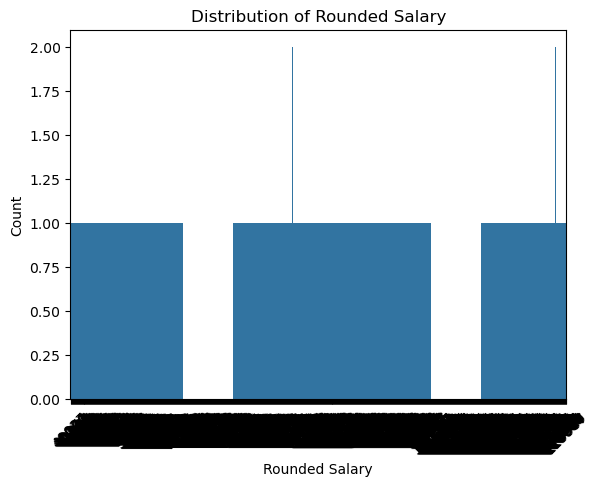

In [83]:
# Create a countplot for the rounded salary 
sns.countplot(data=df, x='salary')
plt.title('Distribution of Rounded Salary')
plt.xlabel('Rounded Salary')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Feature Engineering

In [84]:
df['hire_date'] = pd.to_datetime(df['hire_date'], errors='coerce')
df['experience_years'] = 2025 - df['hire_date'].dt.year
df['experience_years'] = df['experience_years'].fillna(0).astype(int)


# Functions to apply the anonimization

In [85]:
def preprocess_for_ml(df):
    y = df['salary']
    X = df.drop(columns=['salary'])  # Drop the target column (target = salary)

    # Replace '*' with np.nan and fill
    X = X.replace('*', np.nan).fillna('Missing')

    # Encode categorical variables using LabelEncoder
    for col in X.select_dtypes(include='object').columns:
        encoder = LabelEncoder()
        X[col] = encoder.fit_transform(X[col].astype(str))

    return X, y


In [86]:
# Evaluation function to use in both original and anonymized datasets
def evaluate_on_dataset_cv(df, label=''):
    X, y = preprocess_for_ml(df)
    model = RandomForestRegressor(random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    print(f"✅ {label} - MAE (média CV): {-np.mean(scores):.2f}")
    return {'label': label, 'mae_cv': -np.mean(scores)}


In [87]:

# Function to train and evaluate models
def train_and_evaluate(model, X_train, X_test, y_train, y_test, label=''):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Model ({label}) - MAE: {mae:.2f}")
    return mae


In [88]:

# Training and evaluation function for all models
def evaluate_models(X_train, X_test, y_train, y_test):
    models = [
        (RandomForestRegressor(random_state=42), "Random Forest"),
        (LinearRegression(), "Linear Regression"),
        (DecisionTreeRegressor(random_state=42), "Decision Tree"),
        (GradientBoostingRegressor(random_state=42), "Gradient Boosting")
    ]
    
    results = {}
    for model, label in models:
        mae = train_and_evaluate(model, X_train, X_test, y_train, y_test, label)
        results[label] = mae

    return results


## GridSearch with RandomForest

In [89]:
# Reutiliza os dados preparados
X, y = preprocess_for_ml(df_original)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define o espaço de pesquisa
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Inicia o GridSearch
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Treinar
grid_search.fit(X_train, y_train)

# Resultados
print("🔍 Best Parameters:")
print(grid_search.best_params_)
print(f"📉 Best MAE (CV mean): {-grid_search.best_score_:.2f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
🔍 Best Parameters:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
📉 Best MAE (CV mean): 20278.47


In [90]:
def gridsearch_on_anonymized(df_original, k_values):
    results = []

    for k in k_values:
        df_k = apply_k_anonymity(df_original.copy(), k)
        X, y = preprocess_for_ml(df_k)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

        grid_search = GridSearchCV(
            estimator=RandomForestRegressor(random_state=42),
            param_grid=param_grid,
            cv=5,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train, y_train)

        results.append({
            'k': k,
            'best_params': grid_search.best_params_,
            'best_mae': -grid_search.best_score_
        })

    return pd.DataFrame(results)

# ⚠️ Antes disto, garante que df_original tem a coluna 'salary' e está pré-processado corretamente.

gridsearch_results = gridsearch_on_anonymized(df_original, [5, 10, 15, 20])
display(gridsearch_results)


✅ Anonymization for k=5:
 - Unique QID combinations: 75
 - Suppressed cells (NaN): 0 / 3000 (0.00%)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Anonymization for k=10:
 - Unique QID combinations: 69
 - Suppressed cells (NaN): 165 / 3000 (5.50%)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Anonymization for k=15:
 - Unique QID combinations: 26
 - Suppressed cells (NaN): 1743 / 3000 (58.10%)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Anonymization for k=20:
 - Unique QID combinations: 4
 - Suppressed cells (NaN): 2802 / 3000 (93.40%)
Fitting 5 folds for each of 16 candidates, totalling 80 fits


,k,best_params,best_mae
0,5,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",20287.010960
1,10,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",20209.858135
2,15,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",20152.573832
3,20,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",20243.875714


# Anonymity

## K=1

In [91]:
def apply_k_anonymity(df, k):
    df = df.copy()
    
    # Define quasi-identifiers
    QIDs = ['gender', 'department', 'education_level']
    
    # Generalization based on k level
    def generalize(row):
        # Gender
        if k >= 5 and isinstance(row['gender'], str):
            row['gender'] = row['gender'][0]  # Só a inicial
        # City
        if k >= 10 and isinstance(row['city'], str):
            row['city'] = row['city'][:2]    # Só as 2 primeiras letras
        elif k >= 5 and isinstance(row['city'], str):
            row['city'] = row['city'][:3]    # Só as 3 primeiras letras
        # Department
        elif k >= 5 and isinstance(row['department'], str):
            if any(x in row['department'] for x in ['IT', 'Tech', 'Developer']):
                row['department'] = 'Tech'
            elif any(x in row['department'] for x in ['HR', 'Admin']):
                row['department'] = 'Admin'
            else:
                row['department'] = 'Other'

        # Job Titles
        if k >= 10 and isinstance(row['job_titles'], str):
            row['job_titles'] = " ".join(row['job_titles'].split()[:1])
        elif k >= 5 and isinstance(row['job_titles'], str):
            row['job_titles'] = " ".join(row['job_titles'].split()[:2])
        # Hire Date
        try:
            parsed_date = pd.to_datetime(row['hire_date'], errors='coerce')
            if pd.isna(parsed_date):
                row['hire_date'] = 'Missing'
            elif k >= 10:
                row['hire_date'] = parsed_date.year // 10 * 10  # Década
            elif k >= 5:
                row['hire_date'] = parsed_date.year
            elif k >= 2:
                row['hire_date'] = parsed_date.strftime('%Y-%m')
        except:
            row['hire_date'] = 'Missing'
        return row

    df = df.apply(generalize, axis=1)
    # Group by QIDs and get group sizes
    group_sizes = df.groupby(QIDs).size().reset_index(name='counts')

    # Identify groups with fewer than k
    small_groups = group_sizes[group_sizes['counts'] < k]

    # Suppression for small groups
    def suppress(row):
        is_small = ((small_groups[QIDs] == row[QIDs]).all(axis=1)).any()
        if is_small:
            for col in QIDs:
                row[col] = np.nan
        return row

    # Apply suppression
    df = df.apply(suppress, axis=1)

    # Contagem realista de células anonimizadas
    total_qid_cells = df[QIDs].size
    suppressed_cells = df[QIDs].isna().sum().sum()
    percent = (suppressed_cells / total_qid_cells) * 100

    print(f"✅ Anonymization for k={k}:")
    print(f" - Unique QID combinations: {df[QIDs].drop_duplicates().shape[0]}")
    print(f" - Suppressed cells (NaN): {suppressed_cells} / {total_qid_cells} ({percent:.2f}%)")

    return df


## K=2

In [92]:
k = 2
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k2 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=2:
 - Unique QID combinations: 75
 - Suppressed cells (NaN): 0 / 3000 (0.00%)
Model (Random Forest) - MAE: 19407.71
Model (Linear Regression) - MAE: 19008.91
Model (Decision Tree) - MAE: 25835.96
Model (Gradient Boosting) - MAE: 19390.27


## K=5

In [93]:

k = 5
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k5 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=5:
 - Unique QID combinations: 75
 - Suppressed cells (NaN): 0 / 3000 (0.00%)
Model (Random Forest) - MAE: 19577.96
Model (Linear Regression) - MAE: 18963.39
Model (Decision Tree) - MAE: 25395.23
Model (Gradient Boosting) - MAE: 19459.29


## K=10

In [94]:
k = 10
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k10 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=10:
 - Unique QID combinations: 69
 - Suppressed cells (NaN): 165 / 3000 (5.50%)
Model (Random Forest) - MAE: 19403.15
Model (Linear Regression) - MAE: 19004.00
Model (Decision Tree) - MAE: 24721.62
Model (Gradient Boosting) - MAE: 19864.60


## K=15

In [95]:
k = 15
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k15 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=15:
 - Unique QID combinations: 26
 - Suppressed cells (NaN): 1743 / 3000 (58.10%)
Model (Random Forest) - MAE: 19398.66
Model (Linear Regression) - MAE: 18956.83
Model (Decision Tree) - MAE: 23358.82
Model (Gradient Boosting) - MAE: 19365.26


## K=20

In [96]:
k = 20
df_anonymous = apply_k_anonymity(df, k)

X_processed, y_processed = preprocess_for_ml(df_anonymous)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

model_results_k20 = evaluate_models(X_train, X_test, y_train, y_test)


✅ Anonymization for k=20:
 - Unique QID combinations: 4
 - Suppressed cells (NaN): 2802 / 3000 (93.40%)
Model (Random Forest) - MAE: 19189.50
Model (Linear Regression) - MAE: 18845.41
Model (Decision Tree) - MAE: 24185.81
Model (Gradient Boosting) - MAE: 19948.79


## Evaluation on original + anonymized datasets

In [97]:
# Evaluate on original + anonymized datasets
all_results = []

for k in [0, 2, 5, 10, 15, 20]:
    if k == 0:
        df_k = df_original.copy()
        label = "Original"
    else:
        df_k = apply_k_anonymity(df_original.copy(), k)
        label = f"k={k}"
    X, y = preprocess_for_ml(df_k)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_maes = evaluate_models(X_train, X_test, y_train, y_test)
    for model_name, mae in model_maes.items():
        all_results.append({'k': k, 'label': label, 'model': model_name, 'mae': mae})

results_df = pd.DataFrame(all_results)


Model (Random Forest) - MAE: 19457.18
Model (Linear Regression) - MAE: 18989.42
Model (Decision Tree) - MAE: 25166.24
Model (Gradient Boosting) - MAE: 19805.78
✅ Anonymization for k=2:
 - Unique QID combinations: 75
 - Suppressed cells (NaN): 0 / 3000 (0.00%)
Model (Random Forest) - MAE: 19406.14
Model (Linear Regression) - MAE: 18991.89
Model (Decision Tree) - MAE: 25887.07
Model (Gradient Boosting) - MAE: 19342.68
✅ Anonymization for k=5:
 - Unique QID combinations: 75
 - Suppressed cells (NaN): 0 / 3000 (0.00%)
Model (Random Forest) - MAE: 19534.58
Model (Linear Regression) - MAE: 18963.39
Model (Decision Tree) - MAE: 25828.03
Model (Gradient Boosting) - MAE: 19474.68
✅ Anonymization for k=10:
 - Unique QID combinations: 69
 - Suppressed cells (NaN): 165 / 3000 (5.50%)
Model (Random Forest) - MAE: 19412.35
Model (Linear Regression) - MAE: 19004.75
Model (Decision Tree) - MAE: 24506.85
Model (Gradient Boosting) - MAE: 19763.91
✅ Anonymization for k=15:
 - Unique QID combinations: 26


# Attempt to preview salary on the anonymized dataset

In [98]:
# Keep a clean reference to the original salaries
original_salaries = df['salary'].copy()

k = 2 # or any k you want to test
df_anonymous = apply_k_anonymity(df.copy(), k)

✅ Anonymization for k=2:
 - Unique QID combinations: 75
 - Suppressed cells (NaN): 0 / 3000 (0.00%)


## Preprocessing to train

In [99]:
X_processed, _ = preprocess_for_ml(df_anonymous)  
y_true = original_salaries  

# Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_true, test_size=0.2, random_state=42)

# Train a model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🔍 Salary prediction on anonymized data (k={k})")
print(f" - MAE: {mae:.2f}")
print(f" - R² Score: {r2:.4f}")


🔍 Salary prediction on anonymized data (k=2)
 - MAE: 19407.71
 - R² Score: -0.0177


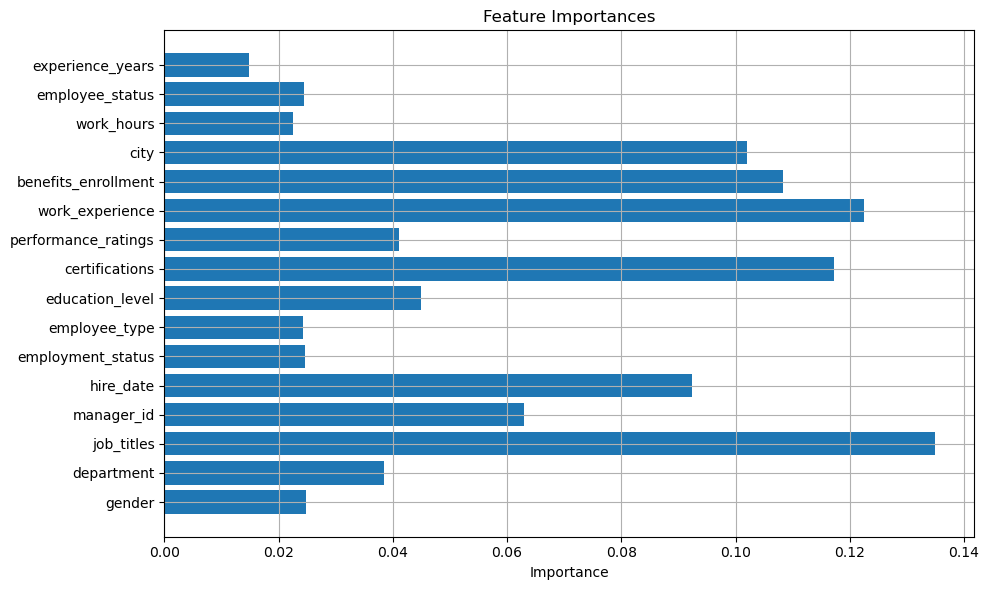

In [100]:
importances = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()

## Results interpretation

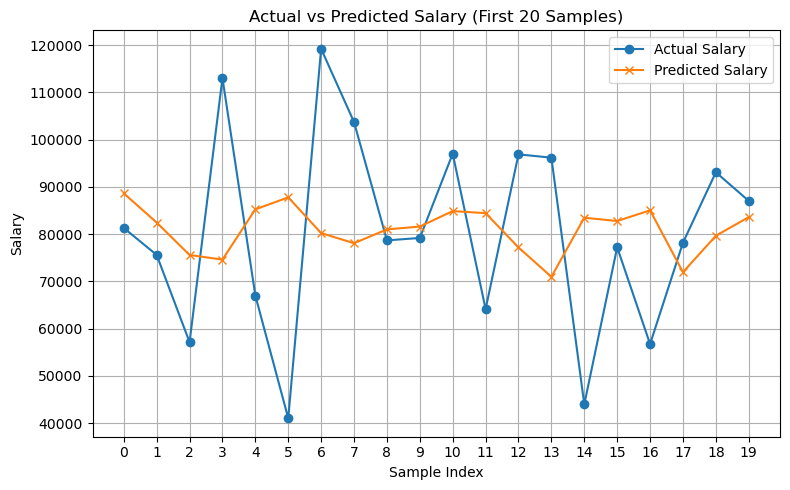

In [101]:
# Create the comparison DataFrame
comparison = pd.DataFrame({
    'Actual Salary': y_test.reset_index(drop=True),
    'Predicted Salary': y_pred
})

comparison_sample = comparison.head(20)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(comparison_sample.index, comparison_sample['Actual Salary'], label='Actual Salary', marker='o')
plt.plot(comparison_sample.index, comparison_sample['Predicted Salary'], label='Predicted Salary', marker='x')
plt.title('Actual vs Predicted Salary (First 20 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Salary')
plt.xticks(comparison_sample.index)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()